# SUPERVISED CLASSIFICATION MODELLING: PROBABILITY OF DEFAULT

The purpose of this model will be to predict the probability that a given customer will default.

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import scikitplot as skplt

#To increase autocomplete response speed
%config IPCompleter.greedy=True

#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

Project path.

In [2]:
project_path = '../..'

Names of data files.

In [3]:
df_name = 'df_input_pd.pickle'

Data importation.

In [4]:
df = pd.read_pickle(project_path + '/02_Data/03_Work/' + df_name)

## MODELLING

As discussed in the design stage of the project, probability of default (PD) model will be based on the logistic regression algorithm. This section aims to find the optimal combination of hyperparameters.

### Feature correlations

As one of the major assumptions of the logistic regression algorithm is the absence of multicollinearity among features, in this section, the existence of strong correlations will be checked.

In [5]:
def corr_strong(dataframe, lower_lim=0.3, upper_lim=1, drop_duplicates=True):
    c = dataframe.corr().unstack().to_frame().reset_index().rename(columns={'level_0':'var_0',
                                                                            'level_1':'var_1',
                                                                            0:'corr'})
    c['corr_sign'] = np.where(c['corr']>=0,'+','-')
    c['corr'] = c['corr'].transform(abs)
    c = c.rename(columns={'corr':'corr_abs'})
    
    condition = (c['corr_abs']>lower_lim) & (c['corr_abs']<upper_lim)
    c = c.loc[condition,:].sort_values(by='corr_abs',ascending=False)
    
    c = c if drop_duplicates==False else c.drop_duplicates(subset=['corr_abs'])
    return(c)

In [6]:
corr = corr_strong(df)
corr.var_1.value_counts()

scoring_oe_mms                  3
installment_qt_mms              2
home_ownership_RENT             2
n_mortages_qt_mms               2
purpose_debt_consolidation      2
revolving_utilization_qt_mms    1
annual_income_qt_mms            1
loan_amount_qt_mms              1
interest_rate_qt_mms            1
term_ 60 months                 1
home_ownership_MORTGAGE         1
dti_qt_mms                      1
Name: var_1, dtype: int64

In [7]:
corr

,var_0,var_1,corr_abs,corr_sign
793,interest_rate_qt_mms,scoring_oe_mms,0.916059,+
830,loan_amount_qt_mms,installment_qt_mms,0.908304,+
66,home_ownership_MORTGAGE,home_ownership_RENT,0.798734,-
680,p_credit_cards_exceeding_75p_disc_te_pd_mms,revolving_utilization_qt_mms,0.629600,+
90,home_ownership_MORTGAGE,n_mortages_qt_mms,0.623418,+
193,purpose_credit_card,purpose_debt_consolidation,0.619206,-
872,n_mortages_qt_mms,home_ownership_RENT,0.597351,-
706,annual_income_qt_mms,installment_qt_mms,0.437392,+
828,loan_amount_qt_mms,annual_income_qt_mms,0.430018,+
18,term_ 36 months,scoring_oe_mms,0.379523,-


As already detected during the exploratory analysis phase, there is a high correlation between scoring and interest_rate features, as well as between loan amount and the monthly installments. After an iterative modelling process, it is found that the scoring and loan_amount features are more predictive than interest_rate and installment, so only the first two will be used in order to avoid these high correlations.

In [8]:
df.drop(columns=['interest_rate_qt_mms','installment_qt_mms'],inplace=True)

In [9]:
corr = corr_strong(df)
corr.var_1.value_counts()

home_ownership_RENT                            2
home_ownership_MORTGAGE                        2
purpose_debt_consolidation                     2
p_credit_cards_exceeding_75p_disc_te_pd_mms    1
annual_income_qt_mms                           1
scoring_oe_mms                                 1
term_ 60 months                                1
loan_amount_qt_mms                             1
n_credit_lines_qt_mms                          1
n_mortages_qt_mms                              1
Name: var_1, dtype: int64

The remaining correlations are mainly due to the one hot encoding process. Lasso-regularised algorithm settings will preferably be selected to mitigate these effects.

### Reserving validation dataset

In [10]:
x = df.drop(columns='target_pd')
y = df.target_pd.copy()

In [11]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Creating the pipe and the dictionary of algorithms, parameters and values to be tested

In [12]:
pipe = Pipeline([('algorithm',LogisticRegression())])

grid = [{'algorithm': [LogisticRegression(solver='saga', n_jobs=-1)],
         'algorithm__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algorithm__C': np.arange(0,1.1,0.1)}]

### Hyperparameter optimization

#### Using grid search

In [13]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 10, 
                           scoring = 'roc_auc',
                           verbose = 3,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

Fitting 10 folds for each of 44 candidates, totalling 440 fits


In [14]:
pd.DataFrame(grid_search.cv_results_)[['param_algorithm__C','param_algorithm__penalty','mean_test_score','std_test_score',
                                       'rank_test_score']].sort_values(by = 'rank_test_score')

,param_algorithm__C,param_algorithm__penalty,mean_test_score,std_test_score,rank_test_score
17,0.4,l1,0.700578,0.008637,1
21,0.5,l1,0.700576,0.008632,2
25,0.6,l1,0.700575,0.008626,3
13,0.3,l1,0.700575,0.008645,4
29,0.7,l1,0.700575,0.008623,5
33,0.8,l1,0.700572,0.008622,6
37,0.9,l1,0.700571,0.008621,7
41,1.0,l1,0.700567,0.008617,8
9,0.2,l1,0.700564,0.008673,9
26,0.6,l2,0.700552,0.008630,10


In [15]:
model.best_estimator_

Pipeline(steps=[('algorithm',
                 LogisticRegression(C=0.4, n_jobs=-1, penalty='l1',
                                    solver='saga'))])

The best parameterisation found corresponds to a logistic regression with lasso regularisation, C=1.

In [16]:
lr = LogisticRegression(n_jobs=-1, C=0.4, penalty='l1', solver='saga')
lr.fit(train_x,train_y)

LogisticRegression(C=0.4, n_jobs=-1, penalty='l1', solver='saga')

## MODEL EVALUATION

Predicting on test dataset:

In [17]:
pred = lr.predict_proba(val_x)[:, 1]

Evaluating on test dataset:

In [18]:
roc_auc_score(val_y, pred)

0.7014653202202464

Feature importances:

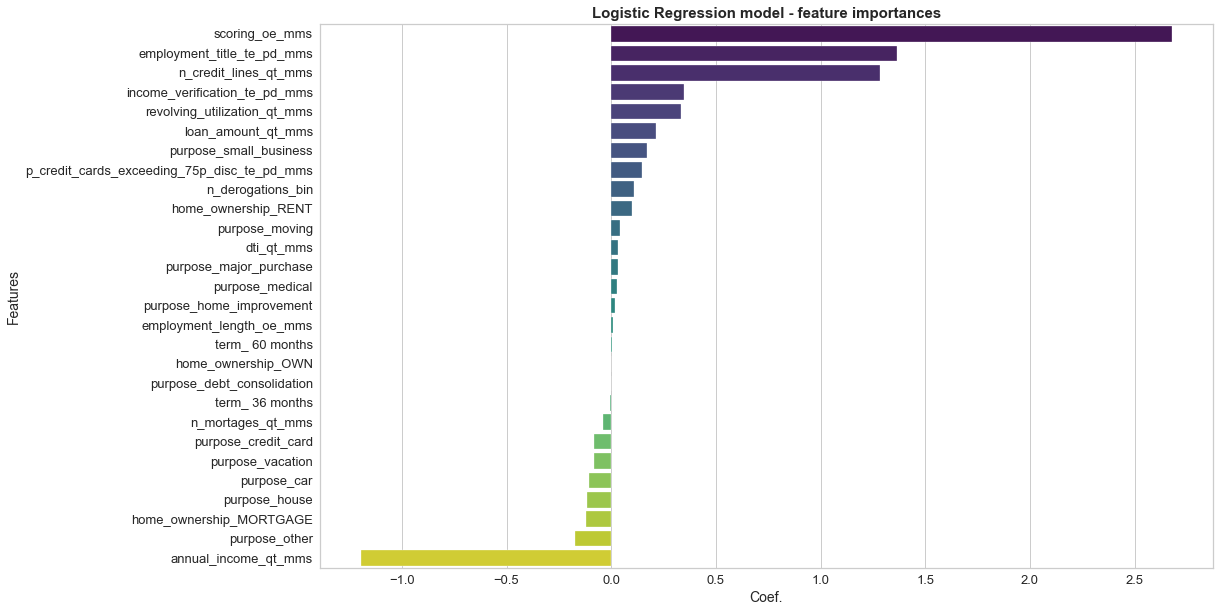

In [19]:
f,ax = plt.subplots(figsize=(16,10))

sns.barplot(data=pd.DataFrame(data=lr.coef_,
             columns=lr.feature_names_in_).T.reset_index() \
                       .rename(columns={'index':'feature',0:'coef'}).sort_values(by='coef',ascending=False),
            x='coef', y='feature',
            palette='viridis')
plt.title(label='Logistic Regression model - feature importances',fontsize=15, fontweight='bold');
plt.xlabel('Coef.',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

## MODEL REPORTING

### Gain Chart

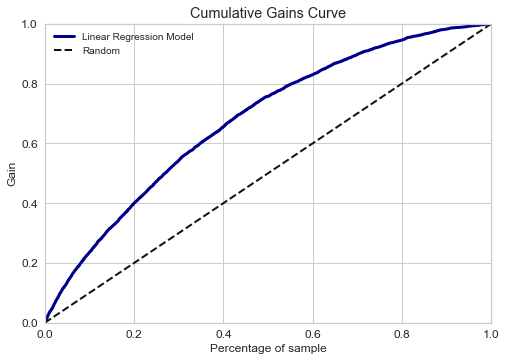

In [37]:
fig, ax = plt.subplots()

skplt.metrics.plot_cumulative_gain(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

#Removing the zeroes class line class and personalising the legend
del ax.lines[0] 
plt.gca().get_lines()[0].set_color("darkblue")
plt.legend(labels = ['Linear Regression Model','Random']);

### Lift Chart

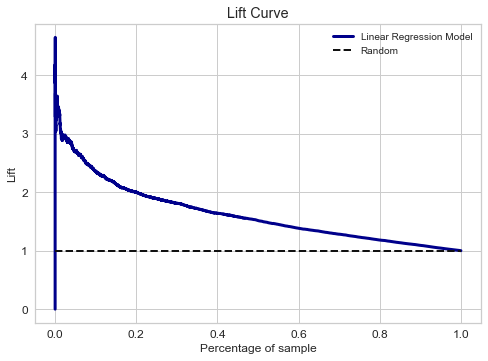

In [38]:
fig, ax = plt.subplots()

skplt.metrics.plot_lift_curve(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

#Removing the zeroes class line class and personalising the legend
del ax.lines[0]    
plt.gca().get_lines()[0].set_color("darkblue")
plt.legend(labels = ['Linear Regression Model','Random']);

### ROC Chart

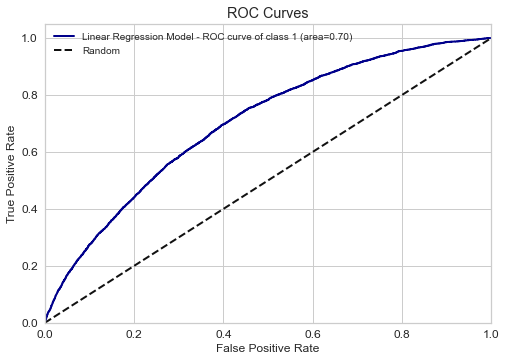

In [40]:
fig, ax = plt.subplots()

skplt.metrics.plot_roc(val_y, lr.predict_proba(val_x), ax=ax,
                       plot_micro=False,
                       plot_macro=False,
                       classes_to_plot=1)
plt.gca().get_lines()[0].set_color("darkblue")
plt.legend(labels = ['Linear Regression Model - ROC curve of class 1 (area=0.70)','Random']);